# Generative Adversarial Network

reference : https://towardsdatascience.com/generate-anime-style-face-using-dcgan-and-explore-its-latent-feature-representation-ae0e905f3974

## Header Program


In [1]:
# Import library create by mysel
from library.directory_handle import DirectoryHandle
import library.image_handle as ImageHandle
import library.data_handle as DataHandle

# Import library for plot image
import matplotlib.pyplot as plt

# Import library for manage model part Core Layers
from keras.layers import Input, Flatten, Dense, Reshape, Lambda, Dropout
# Import library for manage model part Convolution Layers
from keras.layers import Conv2D, Conv2DTranspose
# Import library for manage model part Activation
from keras.layers import Activation, ReLU
# Import Library for manage model part Model Object
from keras.models import Model
# Import Library for manage model part optimizer
from keras.optimizers import Adam, RMSprop
# Import Library about model 
from keras.utils import plot_model
# Import library for load model
from keras.models import load_model
# Import library operation in Keras tensor object
from keras import backend as K

#Import library for normal process
import numpy as np

#Import library for manage clear output
from IPython.display import clear_output

Using TensorFlow backend.


## Prepare Data

In [2]:
# Constant data path to collect directory data
PATH_DATA = "/home/zeabus/Documents/supasan/2019_deep_learning/AnimeFaceData" 

# Part parameter in normal program will require to input
crop = True
color = True
rounds = 10 # Round to train data (epoches)

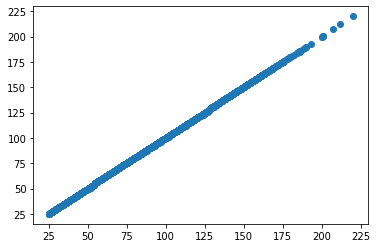

In [3]:
directory_handle = DirectoryHandle( PATH_DATA )
list_file = directory_handle.get_all_file()

width , height = ImageHandle.read_size( list_file )
width = np.array( width )
height = np.array( height )
plt.scatter( width , height )

In [4]:
square_size = int( np.ceil( width.min() ) )
square_size = square_size if square_size % 2 == 0 else square_size + 1
#latent_size = int( np.power( square_size , 2 ) / 4 * 3 )
latent_size = 64
print(f'Will manage by resize image to size {square_size} square and have latent size {latent_size}')

Will manage by resize image to size 26 square and have latent size 64


In [5]:
X_data = ImageHandle.read_all_data( list_file , square_size , color = color , crop = crop )

In [6]:
picture_shape = X_data[0].shape
shape_before_flatten = ( int( picture_shape[0] / 2),
                int( picture_shape[1] / 2),
                16 )

## Setup Model
This part I split step to setup GAN Model to Generator, Descriminator and GAN model
### Part Generator Model

In [7]:
generator_input = Input( shape=(latent_size,),
                name = "generator_input")
generator = Dense( np.prod( shape_before_flatten ),
                name = "generator_neuron1" )( generator_input )
#generator = Activation( "relu",
#                name = "generator_neuron1_activation" )(generator)
generator = Reshape( shape_before_flatten , 
                name = "generator_reshape" )(generator)
generator = Conv2DTranspose( filters = 16,
                           kernel_size = (3,3),
                           strides = 1,
                           padding = "same",
                           name = "generator_convolution1",
                           use_bias = True )(generator)
#generator = Activation( "relu",
#generator = ReLU( max_value = 1 ,
#                name = "generator_convolution1_activation" )(generator)
generator = Conv2DTranspose( filters = 32,
                           kernel_size = (3,3),
                           strides = 2,
                           padding = "same",
                           name = "generator_convolution2" )(generator)
#generator = Activation( "relu",
#generator = ReLU( max_value = 1 ,
#                name = "generator_convolution2_activation" )(generator)
generator_output = Conv2DTranspose( filters = 3,
                           kernel_size = (3,3),
                           strides = 1,
                           padding = "same",
                           name = "generator_output" )(generator)
#generator_output = Activation( "relu",
#generator_output = ReLU( max_value = 1 ,
#                name = "generator_output_activation" )(generator)
generator_model = Model( generator_input , generator_output )
generator_model.name = "generator"
generator_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 64)                0         
_________________________________________________________________
generator_neuron1 (Dense)    (None, 2704)              175760    
_________________________________________________________________
generator_reshape (Reshape)  (None, 13, 13, 16)        0         
_________________________________________________________________
generator_convolution1 (Conv (None, 13, 13, 16)        2320      
_________________________________________________________________
generator_convolution2 (Conv (None, 26, 26, 32)        4640      
_________________________________________________________________
generator_output (Conv2DTran (None, 26, 26, 3)         867       
Total params: 183,587
Trainable params: 183,587
Non-trainable params: 0
___________________________________________________

### Part Discriminator

In [8]:
discriminator_input = Input( picture_shape ,
                    name = "discirminator_input" )
discriminator = Conv2D( filters = 32,
                    kernel_size = (3,3),
                    strides = 1,
                    padding = "same",
                    name = "discriminator_convolution1" )( discriminator_input )
discriminator = Activation( "relu",
                name = "discriminator_convolution1_activation" )(discriminator)
discriminator = Conv2D( filters = 16,
                    kernel_size = (3,3),
                    strides = 2,
                    padding = "same",
                    name = "discriminator_convolution2" )( discriminator )
discriminator = Activation( "relu",
                name = "discriminator_convolution2_activation" )(discriminator)
discriminator = Flatten( name = "discriminator_flatten" )( discriminator )
discriminator = Dropout( 0.2 )( discriminator )
discriminator = Dense( latent_size ,
                name = "discriminator_dense1" )( discriminator )
discriminator = Activation( "sigmoid",
                name = "discriminator_dense1_activation" )( discriminator )
discriminator = Dense( 1 , name = "discriminator_output" )( discriminator )
discriminator_output = Activation( "sigmoid",
                name = "discriminator_output_activation" )( discriminator )
discriminator_model = Model( discriminator_input , discriminator_output )
discriminator_model.name = "discriminator"
discriminator_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discirminator_input (InputLa (None, 26, 26, 3)         0         
_________________________________________________________________
discriminator_convolution1 ( (None, 26, 26, 32)        896       
_________________________________________________________________
discriminator_convolution1_a (None, 26, 26, 32)        0         
_________________________________________________________________
discriminator_convolution2 ( (None, 13, 13, 16)        4624      
_________________________________________________________________
discriminator_convolution2_a (None, 13, 13, 16)        0         
_________________________________________________________________
discriminator_flatten (Flatt (None, 2704)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2704)            

In [9]:
GAN_model = Model( generator_input , discriminator_model( generator_model( generator_input ) ) )
GAN_model.name = "GAN_model"
GAN_model.summary()

Model: "GAN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 64)                0         
_________________________________________________________________
generator (Model)            (None, 26, 26, 3)         183587    
_________________________________________________________________
discriminator (Model)        (None, 1)                 178705    
Total params: 362,292
Trainable params: 362,292
Non-trainable params: 0
_________________________________________________________________


## Compile Model

In [10]:
# Parameter About Training
enable_report = True
round_train = 2
batch_check_point = 10
epochs_discriminator = 1
epochs_GAN = 2
verbose = 1 # 0 is silencs 1 is progress bar 2 is result?
batch_size = 2048
round_batch = int( np.ceil( len(X_data) / batch_size) )
list_latent_vector = []
size_latent_vector = (  batch_size , latent_size )
real_image = np.array( X_data ).astype( np.float ) / 255

In [11]:
GAN_optimizer = RMSprop( lr = 0.001 )
#GAN_optimizer = Adam( lr = 0.0005 )
GAN_model.compile( optimizer = GAN_optimizer,
                     loss = "binary_crossentropy", 
                     metrics=[ 'accuracy' ] )
discriminator_optimizer = RMSprop( lr = 0.0005 )
#discriminator_optimizer = Adam( lr = 0.0005 )
discriminator_model.compile( optimizer = discriminator_optimizer,
                     loss = "binary_crossentropy", 
                     metrics=[ 'accuracy' ] )

In [ ]:
GAN_model.load_weights( "temporary_checkpoint_weights.h5")

## Train Model

In [12]:
discriminator_history = { 'loss' : [] , 'accuracy' : [] }
gan_history = { 'loss' : [] , 'accuracy' : [] }
for count_round in range( round_train ):
    discriminator_loss = []
    discriminator_accuracy = []
    gan_loss = []
    gan_accuracy = []

    start = 0
    count_latent = 0
#    all_latent_vector = np.random.normal( 0 , 1 , size = ( round_batch , size_latent_vector[0] , size_latent_vector[1]) )
    while( start < real_image.shape[0] ):
#        latent_vector = np.random.randint( 0 , 256 , size = size_latent_vector ).astype( np.float ) / 255
        latent_vector = np.random.normal( 0 , 1 , size= size_latent_vector )
#        latent_vector = all_latent_vector[ count_latent ]
        fake_image = generator_model.predict( latent_vector )
        if count_latent % batch_check_point == 0 :
            fig, axes = plt.subplots(2, 5)
            temp = 0
            for i in range(2):
                for j in range(5):
                    axes[i, j].imshow(fake_image[temp] ) 
                    axes[i, j].axis('off')
                    temp += 1
            plt.show()
        
#        print( f'Data batch index {count_latent+1}/{round_batch} on round {count_round+1}/{round_train}')
        stop = start + batch_size
        if stop > real_image.shape[0] : stop = real_image.shape[0]

        all_image = np.concatenate( [ real_image[ start:stop ],
                    fake_image ] )
        label_image = np.concatenate( [
                np.ones( ( stop - start , 1 ) ),
                np.zeros( ( size_latent_vector[0] , 1 ) )
            ] )
#        label_image += 0.05 * np.random.random( label_image.shape )    
        # Train Discriminator
        if enable_report : print( "===> discriminator" , end = "" if verbose == 0 else "\n" )
#        d_loss , d_accuracy = discriminator_model.train_on_batch( all_image , label_image )
        d_history = discriminator_model.fit( all_image , label_image, epochs = epochs_discriminator, verbose = verbose )
        if verbose == 0 and enable_report:
            print( f' Loss {np.mean(d_history.history["loss"]):10.6f} Accuracy {np.mean(d_history.history["accuracy"]):10.6f}')

            
#======= Train Generator
        
        ## Before train must to disable train discriminator
        discriminator_model.trainable = False
        GAN_model.compile( optimizer = GAN_optimizer,
                        loss = "binary_crossentropy", 
                        metrics=[ 'accuracy' ] )
        discriminator_model.compile( optimizer = discriminator_optimizer,
                        loss = "binary_crossentropy", 
                        metrics=[ 'accuracy' ] )
        ## End part disable train discriminator
        
        if enable_report : print( "===> GAN" , end = "" if verbose == 0 else "\n" )        
#        latent_vector = np.random.randint( 0 , 256 , size = size_latent_vector ).astype( np.float ) / 255
        latent_vector = np.random.normal( 0 , 1 , size= size_latent_vector )
        g_history = GAN_model.fit( latent_vector, np.ones( ( size_latent_vector[0] , 1 ) ),
                                  epochs = epochs_GAN ,
                                  verbose = verbose )
#        g_loss , g_accuracy = GAN_model.train_on_batch( latent_vector, np.ones( ( size_latent_vector[0] , 1 ) ) )
        if verbose == 0 and enable_report :
            print( f' Loss {np.mean(g_history.history["loss"]):10.6f} Accuracy {np.mean(g_history.history["accuracy"]):10.6f}')
            
        ## After train must to enable train discriminator
        discriminator_model.trainable = True
        GAN_model.compile( optimizer = GAN_optimizer,
                        loss = "binary_crossentropy", 
                        metrics=[ 'accuracy' ] )
        discriminator_model.compile( optimizer = discriminator_optimizer,
                        loss = "binary_crossentropy", 
                        metrics=[ 'accuracy' ] )

#======== Part add data to report
#        discriminator_loss.append( d_loss )
#        discriminator_accuracy.append( d_accuracy )
#        gan_loss.append( g_loss )
#        gan_accuracy.append( g_accuracy )
        discriminator_loss += d_history.history[ 'loss']
        discriminator_accuracy += d_history.history[ 'accuracy' ]
        gan_loss += g_history.history[ 'loss' ]
        gan_accuracy += g_history.history[ 'accuracy' ]
        start = stop        
        count_latent += 1
        
        if count_latent % batch_check_point == 0 :
            clear_output()
            print( f'At {count_latent}/{round_batch} round {count_round+1}/{round_train}')
            print( f'=disciminator : loss {np.mean( discriminator_loss ) } and accuracy {np.mean( discriminator_accuracy ) }' )
            print( f'==========gan : loss {np.mean(gan_loss)} and accuracy {np.mean(gan_accuracy) }')        
        
        if count_latent % (batch_check_point * 2 ) == 0:
            GAN_model.save_weights( "temporary_checkpoint_weights.h5")
            GAN_model.save( "temporary_checkpoint_model.h5")   
         
    clear_output()
    print( f'Summary round {count_round+1}/{round_train}')  
    print( f'=disciminator : loss {np.mean( discriminator_loss ) } and accuracy {np.mean( discriminator_accuracy ) }' )
    print( f'==========gan : loss {np.mean(gan_loss)} and accuracy {np.mean(gan_accuracy) }')
    GAN_model.save_weights( "temporary_checkpoint_weights.h5")
    GAN_model.save( "temporary_checkpoint_model.h5")
    
    discriminator_history['loss'].append( discriminator_loss )
    discriminator_history['accuracy'].append( discriminator_accuracy )
    gan_history['loss'].append( gan_loss )
    gan_history['accuracy'].append( gan_accuracy )

Summary round 2/2
=disciminator : loss 0.13602144337788044 and accuracy 0.9725617170333862
==========gan : loss 0.06299522364693955 and accuracy 0.99176025390625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

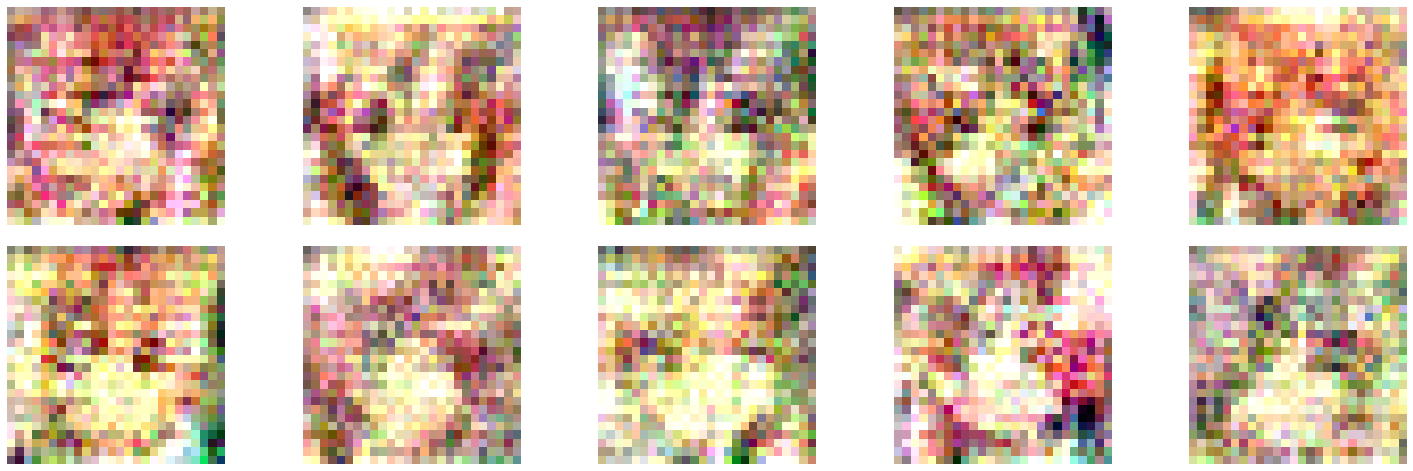

In [13]:
latent_random = np.random.normal( 0 , 1 , size=( 10 , latent_size ))
#latent_random = np.random.randint( 0 , 256 , size = ( 10 , latent_size ) ).astype( np.float ) / 255
DataHandle.plot( latent_random , generator_model , dest_type = float )

In [15]:
generator_model.predict( np.random.normal( 0 , 1 , size=( 1 , latent_size ) ) )

array([[[[0.4658341 , 0.44914478, 0.36996076],
         [0.5298631 , 0.60205793, 0.636023  ],
         [0.70123154, 0.65052205, 0.65864766],
         ...,
         [0.8852561 , 1.0609791 , 0.938498  ],
         [0.821536  , 1.0781054 , 0.7736599 ],
         [1.0260736 , 0.96011466, 0.97270525]],

        [[0.78689605, 0.71339923, 0.6355262 ],
         [0.73132545, 0.61702067, 0.46310717],
         [0.9086523 , 0.7772735 , 0.6776767 ],
         ...,
         [1.5381322 , 1.4421086 , 1.0719527 ],
         [1.3363792 , 1.5681748 , 0.9377    ],
         [1.4744887 , 0.9847098 , 0.8479488 ]],

        [[0.9353736 , 0.5492552 , 0.7019154 ],
         [0.5912179 , 0.37883407, 0.45582741],
         [0.7470842 , 0.46032545, 0.3793828 ],
         ...,
         [1.0960273 , 1.2626019 , 1.0395666 ],
         [1.2047449 , 1.419477  , 0.99707806],
         [1.2743716 , 1.1307989 , 0.83454794]],

        ...,

        [[0.63206506, 0.5386459 , 0.5277291 ],
         [1.0109892 , 0.8645934 , 0.75882244]